## UPOZORENJA
- ćelija za učitavanje podataka treba malo više vremena (get_user_data), pozvati jednom i nakon toga zakomentirati

## TODO-ovi
- smisliti kako ćemo odabrati bolji dio podataka

In [1]:
import numpy as np
import scipy
from scipy.sparse import csc_matrix, bmat, save_npz
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import copy

## Data preparation
- reading user data from given files (we are considering only users that are in some group here)
- random sample of filtered users
- normalizing user data (renaming users to elements of $\{0, ..., n-1\}$)

In [2]:
def normalize_users(users):
    usrs = list(set(users.keys()).union(set([link  for key in users for link in users[key]["links"] ])))
    groups = list(set([group for key in users for group in users[key]["groups"] ]))
    normalized_users = {}
    for user in users:
        normalized_users[usrs.index(user)] = {}
        normalized_users[usrs.index(user)]["links"] = [usrs.index(link) for link in users[user]["links"]]
        normalized_users[usrs.index(user)]["groups"] = [groups.index(group) for group in users[user]["groups"]]
    return normalized_users    

In [3]:
def filter_users(user_number, all_users):
    # add any additional filters here if needed (ex. at least 2 groups and 3 links)
    
    # filters like this will work only if set for groups because in the next step we are 
    # filtering links that aren't in our subgraph
    users = copy.deepcopy(all_users)
    print("Number of users in full dataset : " + str(len(users)))
    users = {user: users[user] for user in users if len(users[user]["links"]) >= 2 and len(users[user]["groups"]) >= 2}
    print("Number of users in filtered dataset : " + str(len(users)))
    
    keys = random.sample(users.keys(), user_number)
    users = {key: users[key] for key in keys}
    
    #first eliminate any links that remained in the graph and shouldn't be there
    for user in users:
        users[user]["links"] = list(filter(lambda link: link in users.keys(), users[user]["links"]))
        
    return normalize_users(users)

In [4]:
def get_user_data(links_path, groups_path):
    # return a list of two dictionaries-users and groups
    # users-return all user data where every user is in at least one group
    links = np.loadtxt(links_path)
    groups = np.loadtxt(groups_path)
    users = {} # key is user, value is dict containing all of his links and all of his groups
    groups_info = {} # key is group, value is dict containing all of its users
    
    for edge in groups:
        if edge[0] not in users:
            users[edge[0]] = { "links": [], "groups":[] }
        users[edge[0]]["groups"].append(edge[1])
        if edge[1] not in groups_info:
            groups_info[edge[1]] = { "users": [] }
        groups_info[edge[1]]["users"].append(edge[0])
        
    for link in links:
        if (link[0] in users) and (link[1] in users):
            users[link[0]]["links"].append(link[1])
    
    return [users, groups_info]

In [5]:
def user_connections(user, groups_users_list):
    # return a list of all user's friends and group friends
    connections=[friend for friend in groups_users_list[0][user]["links"]]
    for group in groups_users_list[0][user]["groups"]:
        for friend in groups_users_list[1][group]["users"]:
            connections.append(friend)
    return list(set(connections))
    

In [6]:
def tree(final_network, last_added, k, groups_users_list):
    #  second iteration: last_added = [user_connections(user) for user in last_added] - final_network 
    l=[]
    if k==0:
        return final_network
    else:
        tree_level=[]
        for friend in last_added:
            tree_level.extend(user_connections(friend, groups_users_list))
        last_added=list(set(tree_level)-set(final_network))
        final_network.extend(last_added)
        return tree(final_network, last_added, k-1, groups_users_list)

In [7]:
def get_adjacency_matrix(users, key, row_num, col_num):
    # constructs adjacency matrix
    # rows are indexed by user
    # cols are indexed based on the key
    row = np.array([])
    column = np.array([])
    value = np.array([])
    
    for user in users:
        for element in users[user][key]:
            row = np.append(row, user)
            column = np.append(column, element)
            value = np.append(value, 1)
    
    s = csc_matrix((value, (row, column)), shape = (row_num, col_num))
    return s

In [8]:
# load data
# this takes some time so comment it out after first run
%time all_users_and_groups = get_user_data("data/release-youtube-links.txt", "data/release-youtube-groupmemberships.txt")

Wall time: 33.1 s


In [9]:
final_network = [1.0]
last_added = [1.0]
max_tree_level = 2
all_users = {user: all_users_and_groups[0][user] for user in tree(final_network, last_added, max_tree_level, all_users_and_groups)}

In [10]:
def print_basic_stats(dataset, dataset_name):
    print(dataset_name)
    print("median:", np.median(dataset), "average:", np.mean(dataset), 
            "max:", np.amax(dataset), "minimum", np.amin(dataset))

def get_network_stats(users):
    all_users = np.array(list(users.keys()))
    user_link_count = np.array([len(users[user]["links"]) for user in all_users])
    user_group_count = np.array([len(users[user]["groups"]) for user in all_users])
    
    groups = np.unique(np.array([group for user in users for group in users[user]["groups"]]))
    group_user_count = np.zeros(len(groups))
    # user count of groups[i] is located at group_user_count[i]
    for user in users:
        for group in users[user]["groups"]:
            index, = np.where(groups == group)
            if len(index) != 1: raise Exception("There are duplicates in your groups array. Check for error.")
            group_user_count[index[0]] += 1  # we can use group_user_count[group] here but this is more general

    # sad za sve ovo neke statistike
    fig1, axs1 = plt.subplots(1, 2, constrained_layout=True, squeeze=True)
    axs1[0].boxplot(user_link_count)
    axs1[0].set_title("User link boxplot")
    axs1[1].hist(user_link_count)
    axs1[1].set_title("User link histogram")
    print_basic_stats(user_link_count, "User link count")
    
    fig2, axs2 = plt.subplots(1, 2, constrained_layout=True, squeeze=True)
    axs2[0].boxplot(user_group_count)
    axs2[0].set_title("User group boxplot")
    axs2[1].hist(user_group_count)
    axs2[1].set_title("User group histogram")
    print_basic_stats(user_group_count, "User group count")

    fig3, axs3 = plt.subplots(1, 2, constrained_layout=True, squeeze=True)
    axs3[0].boxplot(group_user_count)
    axs3[0].set_title("Group user boxplot")
    axs3[1].hist(group_user_count)
    axs3[1].set_title("Group user histogram")
    print_basic_stats(group_user_count, "Group user count")

    plt.show()


In [11]:
# number of users
# WARNING: small number of users will usually result in a small number of links between users
k = 15000

In [12]:
# quickly gets a filtered subset of users
filtered_users = filter_users(k, all_users)

Number of users in full dataset : 63770
Number of users in filtered dataset : 22650


C:\Users\kbasi\AppData\Local\Temp/ipykernel_9816/3829322699.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = random.sample(users.keys(), user_number)


User link count
median: 3.0 average: 9.4408 max: 804 minimum 0
User group count
median: 4.0 average: 7.289933333333333 max: 1035 minimum 2
Group user count
median: 2.0 average: 6.415312408330889 max: 1776.0 minimum 1.0


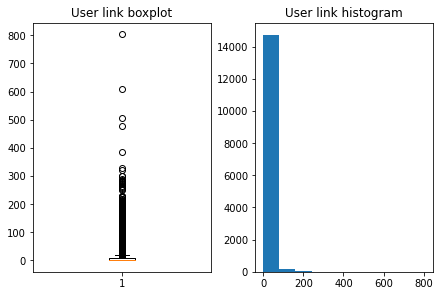

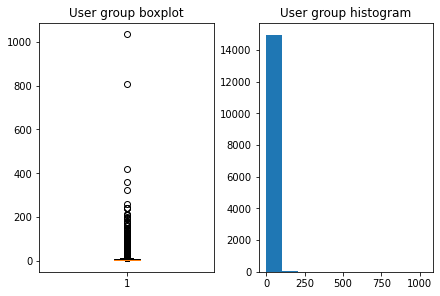

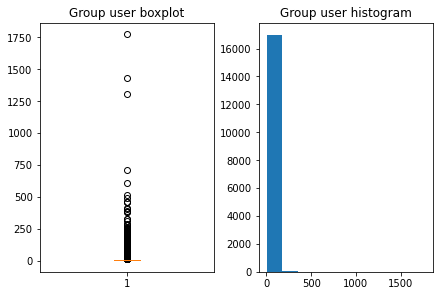

In [13]:
get_network_stats(filtered_users)


In [14]:
len(filtered_users)

15000

In [15]:
# S matrix, matrix of links between users
s = get_adjacency_matrix(filtered_users, "links", len(filtered_users), len(filtered_users))
s

<15000x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 141612 stored elements in Compressed Sparse Column format>

In [16]:
# A matrix, affiliation matrix, links between users and groups
# how many groups are there?
a = get_adjacency_matrix(filtered_users, "groups", len(filtered_users), len(set([group for user in filtered_users for group in filtered_users[user]["groups"]])))
a

<15000x17045 sparse matrix of type '<class 'numpy.float64'>'
	with 109349 stored elements in Compressed Sparse Column format>

## Split data into training and testing

In [17]:
a_train = a.toarray()
for row in a_train:
    ones = np.transpose(row.nonzero())
    indices = np.random.randint(len(ones), size = round(len(ones)*0.3))
    row[ones[indices]] = 0
a_test = csc_matrix(a - a_train)

In [18]:
for row in a_train:
    ones = np.transpose(row.nonzero())
    indices = np.random.randint(len(ones), size = round(len(ones)*0.3))
    row[ones[indices]] = 0
a_val = csc_matrix(a - a_train - a_test)

In [19]:
save_npz("data/s.npz", s)
save_npz("data/a.npz", a)
save_npz("data/a_train.npz", csc_matrix(a_train))
save_npz("data/a_val.npz", a_val)
save_npz("data/a_test.npz", a_test)